In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Walk data
WALK_FILE_NAME = '/home/ollie/Documents/PlatformIO/Projects/lokata/data/raw/walk_data_20260107-090119.csv'
walk_df = pd.read_csv(WALK_FILE_NAME)    # 2. Conversion & Cleaning
# Convert integer Lat/Lon to degrees
walk_df['Lat_deg'] = walk_df['Lat'] / 1e7
walk_df['Lon_deg'] = walk_df['Lon'] / 1e7
# Remove points where Lat/Lon is exactly 0 (GPS errors)
# Remove points that are empty/NaN
walk_df = walk_df[ (walk_df['Lat_deg'] != 0) & (walk_df['Lon_deg'] != 0) ]
walk_df = walk_df.dropna(subset=['Lat_deg', 'Lon_deg'])
# Rename 'Millis' to 'Micros'
walk_df.rename(columns={'Millis': 'Micros'}, inplace=True)

# Calibration data
CAL_FILE_NAME = '/home/ollie/Documents/PlatformIO/Projects/lokata/data/raw/walk_data_20260109-222545.csv'
cal_df = pd.read_csv(CAL_FILE_NAME)
# Convert integer Lat/Lon to degrees
walk_df['Lat_deg'] = walk_df['Lat'] / 1e7
walk_df['Lon_deg'] = walk_df['Lon'] / 1e7
# Rename 'Millis' to 'Micros'
cal_df.rename(columns={'Millis': 'Micros'}, inplace=True)


In [9]:
def calibrate_sensors_robust(df):
    results = {}
    
    # --- 1. ROBUST GYRO BIAS ---
    # (Same as before, checking for stillness)
    acc_mag = np.sqrt(df['Ax']**2 + df['Ay']**2 + df['Az']**2)
    # We use a smaller window and stricter variance for better lock
    rolling_var = acc_mag.rolling(window=50).var()
    best_window_idx = rolling_var.idxmin()
    
    start_idx = max(0, best_window_idx - 50)
    static_df = df.iloc[start_idx : best_window_idx]
    
    results['gyro_bias'] = np.array([
        static_df['Gx'].mean(),
        static_df['Gy'].mean(),
        static_df['Gz'].mean()
    ])
    
    # --- 2. ROBUST MAGNETOMETER OFFSET ---
    # Instead of min() and max(), we use percentiles to crop out the top/bottom 2% of outliers
    # This ignores the "tails" that were ruining your center point.
    
    mx_min, mx_max = np.percentile(df['Mx'], [2, 98])
    my_min, my_max = np.percentile(df['My'], [2, 98])
    mz_min, mz_max = np.percentile(df['Mz'], [2, 98])
    
    # Calculate center from the "dense core" of the data
    mag_offset = np.array([
        (mx_min + mx_max) / 2.0,
        (my_min + my_max) / 2.0,
        (mz_min + mz_max) / 2.0
    ])
    results['mag_offset'] = mag_offset
    
# --- 3. DIAGNOSTICS ---
    print("--- CALIBRATION RESULTS ---")
    print(f"Static Period Found at Index: {start_idx} to {best_window_idx}")
    print(f"Gyro Bias (deg/s):  X={results['gyro_bias'][0]:.3f}, Y={results['gyro_bias'][1]:.3f}, Z={results['gyro_bias'][2]:.3f}")
    print(f"Mag Offset (uT):    X={results['mag_offset'][0]:.3f}, Y={results['mag_offset'][1]:.3f}, Z={results['mag_offset'][2]:.3f}")
    return results

# Run the new calibration
cal_params = calibrate_sensors_robust(cal_df)

# --- RE-PLOT TO VERIFY ---
# (Run your plotting code again here to see the red blob center itself)

--- CALIBRATION RESULTS ---
Static Period Found at Index: 2105 to 2155
Gyro Bias (deg/s):  X=1.371, Y=4.539, Z=-0.173
Mag Offset (uT):    X=42.105, Y=20.075, Z=18.605


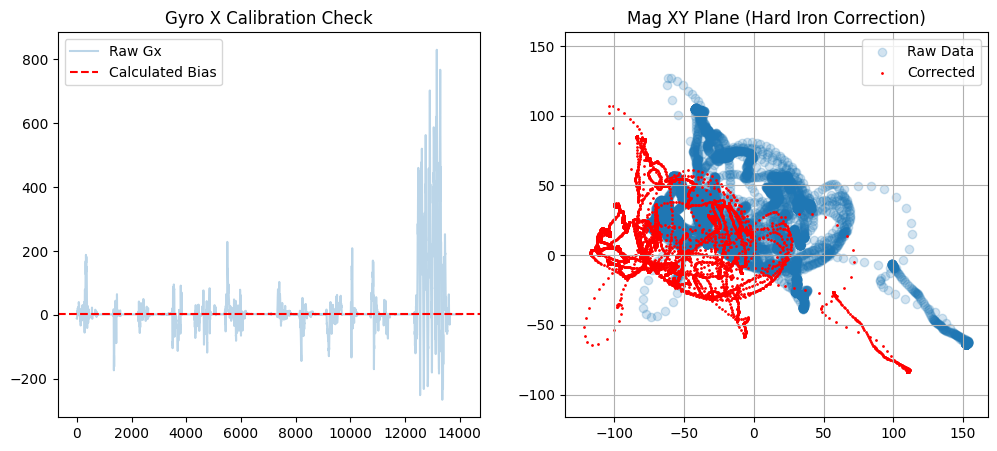

In [11]:
# --- VISUALIZATION OF CALIBRATION ---
if cal_params:
    plt.figure(figsize=(12, 5))

    # Plot 1: Gyroscope (Check if we found the still part)
    plt.subplot(1, 2, 1)
    plt.plot(cal_df['Gx'], label='Raw Gx', alpha=0.3)
    plt.axhline(cal_params['gyro_bias'][0], color='r', linestyle='--', label='Calculated Bias')
    plt.title("Gyro X Calibration Check")
    plt.legend()

    # Plot 2: Magnetometer (Check if it looks centered)
    # We plot X vs Y. If calibrated, it should be a circle centered at (0,0).
    plt.subplot(1, 2, 2)
    plt.scatter(cal_df['Mx'], cal_df['My'], alpha=0.2, label='Raw Data')
    plt.scatter(cal_df['Mx'] - cal_params['mag_offset'][0], 
                cal_df['My'] - cal_params['mag_offset'][1], 
                color='r', s=1, label='Corrected')
    plt.title("Mag XY Plane (Hard Iron Correction)")
    plt.axis('equal') # Important to see if it's circular
    plt.legend()
    plt.grid(True)

    plt.show()

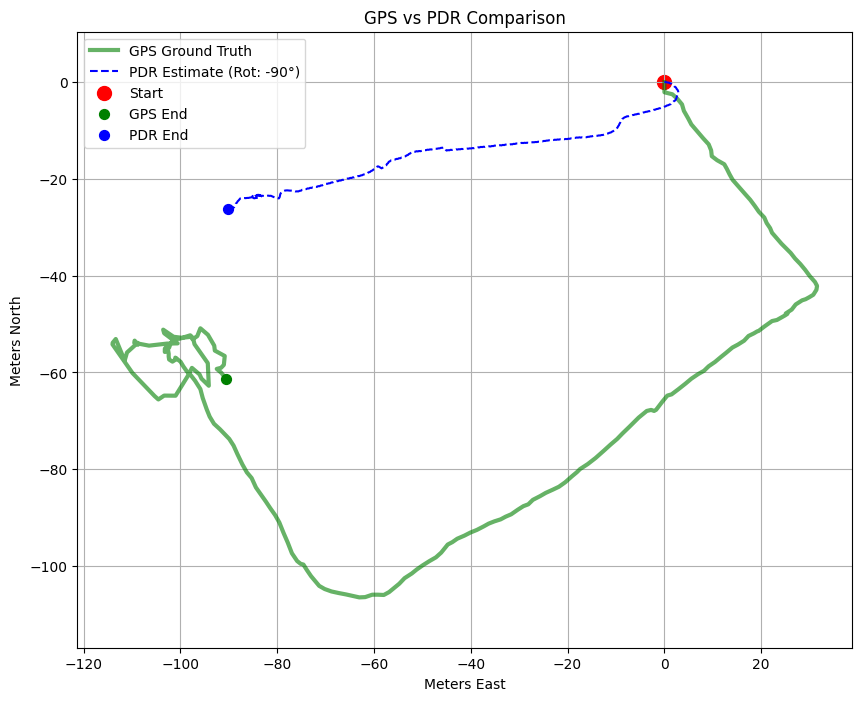

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. SETUP & CLASSES ------------------------------------------------------
class MadgwickAHRS:
    def __init__(self, sampleperiod=0.02, beta=0.1):
        self.sampleperiod = sampleperiod
        self.beta = beta
        self.q = np.array([1.0, 0.0, 0.0, 0.0])

    def update(self, gyro, acc, mag):
        q = self.q
        gx, gy, gz = gyro
        ax, ay, az = acc
        mx, my, mz = mag
        
        # Normalize accel
        norm = np.sqrt(ax*ax + ay*ay + az*az)
        if norm == 0: return
        ax, ay, az = ax/norm, ay/norm, az/norm

        # Normalize mag
        norm = np.sqrt(mx*mx + my*my + mz*mz)
        if norm == 0: return
        mx, my, mz = mx/norm, my/norm, mz/norm

        # Rotate mag to earth frame (Simplified Flux)
        hx = mx*(q[0]**2 + q[1]**2 - q[2]**2 - q[3]**2) - 2*my*(q[0]*q[3] - q[1]*q[2]) + 2*mz*(q[0]*q[2] + q[1]*q[3])
        hy = 2*mx*(q[0]*q[3] + q[1]*q[2]) + my*(q[0]**2 - q[1]**2 + q[2]**2 - q[3]**2) - 2*mz*(q[0]*q[1] - q[2]*q[3])
        bx = np.sqrt(hx*hx + hy*hy)
        bz = 2*mx*(q[1]*q[3] - q[0]*q[2]) + 2*my*(q[0]*q[1] + q[2]*q[3]) + mz*(q[0]**2 - q[1]**2 - q[2]**2 + q[3]**2)

        # Gradient Descent
        s0 = -2*q[2]*(2*q[1]*q[3] - 2*q[0]*q[2] - ax) + 2*q[1]*(2*q[0]*q[1] + 2*q[2]*q[3] - ay) - 2*bz*q[2]*(2*bx*(0.5 - q[2]**2 - q[3]**2) + 2*bz*(q[1]*q[3] - q[0]*q[2]) - mx) + (-2*bx*q[3] + 2*bz*q[1])*(2*bx*(q[1]*q[2] - q[0]*q[3]) + 2*bz*(q[0]*q[1] + q[2]*q[3]) - my) + 2*bx*q[2]*(2*bx*(q[0]*q[2] + q[1]*q[3]) + 2*bz*(0.5 - q[1]**2 - q[2]**2) - mz)
        s1 = 2*q[3]*(2*q[1]*q[3] - 2*q[0]*q[2] - ax) + 2*q[0]*(2*q[0]*q[1] + 2*q[2]*q[3] - ay) - 4*q[1]*(1 - 2*q[1]**2 - 2*q[2]**2 - az) + 2*bz*q[3]*(2*bx*(0.5 - q[2]**2 - q[3]**2) + 2*bz*(q[1]*q[3] - q[0]*q[2]) - mx) + (2*bx*q[2] + 2*bz*q[0])*(2*bx*(q[1]*q[2] - q[0]*q[3]) + 2*bz*(q[0]*q[1] + q[2]*q[3]) - my) + (2*bx*q[3] - 4*bz*q[1])*(2*bx*(q[0]*q[2] + q[1]*q[3]) + 2*bz*(0.5 - q[1]**2 - q[2]**2) - mz)
        s2 = -2*q[0]*(2*q[1]*q[3] - 2*q[0]*q[2] - ax) + 2*q[3]*(2*q[0]*q[1] + 2*q[2]*q[3] - ay) - 4*q[2]*(1 - 2*q[1]**2 - 2*q[2]**2 - az) + (-4*bx*q[2] - 2*bz*q[0])*(2*bx*(0.5 - q[2]**2 - q[3]**2) + 2*bz*(q[1]*q[3] - q[0]*q[2]) - mx) + (2*bx*q[1] + 2*bz*q[3])*(2*bx*(q[1]*q[2] - q[0]*q[3]) + 2*bz*(q[0]*q[1] + q[2]*q[3]) - my) + (2*bx*q[0] - 4*bz*q[2])*(2*bx*(q[0]*q[2] + q[1]*q[3]) + 2*bz*(0.5 - q[1]**2 - q[2]**2) - mz)
        s3 = 2*q[1]*(2*q[1]*q[3] - 2*q[0]*q[2] - ax) + 2*q[2]*(2*q[0]*q[1] + 2*q[2]*q[3] - ay) + (-2*bx*q[3] + 2*bz*q[1])*(2*bx*(0.5 - q[2]**2 - q[3]**2) + 2*bz*(q[1]*q[3] - q[0]*q[2]) - mx) + (-2*bx*q[0] + 2*bz*q[2])*(2*bx*(q[1]*q[2] - q[0]*q[3]) + 2*bz*(q[0]*q[1] + q[2]*q[3]) - my) + 2*bx*q[1]*(2*bx*(q[0]*q[2] + q[1]*q[3]) + 2*bz*(0.5 - q[1]**2 - q[2]**2) - mz)
        
        norm = np.sqrt(s0*s0 + s1*s1 + s2*s2 + s3*s3)
        if norm > 0: s0, s1, s2, s3 = s0/norm, s1/norm, s2/norm, s3/norm

        qDot1 = 0.5 * (-q[1]*gx - q[2]*gy - q[3]*gz) - self.beta * s0
        qDot2 = 0.5 * (q[0]*gx + q[2]*gz - q[3]*gy) - self.beta * s1
        qDot3 = 0.5 * (q[0]*gy - q[1]*gz + q[3]*gx) - self.beta * s2
        qDot4 = 0.5 * (q[0]*gz + q[1]*gy - q[2]*gx) - self.beta * s3

        q[0] += qDot1 * self.sampleperiod
        q[1] += qDot2 * self.sampleperiod
        q[2] += qDot3 * self.sampleperiod
        q[3] += qDot4 * self.sampleperiod
        
        norm = np.sqrt(q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2)
        self.q = q / norm
        return self.q

def rotate_vec(q, vec):
    w, x, y, z = q
    vx, vy, vz = vec
    rx = vx*(1 - 2*y*y - 2*z*z) + vy*(2*x*y - 2*z*w) + vz*(2*x*z + 2*y*w)
    ry = vx*(2*x*y + 2*z*w) + vy*(1 - 2*x*x - 2*z*z) + vz*(2*y*z - 2*x*w)
    rz = vx*(2*x*z - 2*y*w) + vy*(2*y*z + 2*x*w) + vz*(1 - 2*x*x - 2*y*y)
    return np.array([rx, ry, rz])

def get_heading(q):
    return np.arctan2(2.0*(q[1]*q[2] + q[0]*q[3]), q[0]**2 + q[1]**2 - q[2]**2 - q[3]**2)

# --- 2. GENERATE PDR PATH ----------------------------------------------------

# (Assumes 'cal_params' exists from previous step)
# If not, use dummy or run calibration code first
if 'cal_params' not in locals():
    print("Warning: cal_params not found. Using defaults.")
    cal_params = {'gyro_bias': np.zeros(3), 'mag_offset': np.zeros(3)}

gyro_bias = cal_params['gyro_bias']
mag_offset = cal_params['mag_offset']

# Initialization
ahrs = MadgwickAHRS(beta=0.1)
current_x, current_y = 0, 0
pdr_path = [] # Format: [timestamp_micros, x, y]
step_detected = False
last_step_time_sec = 0
k_weinberg = 0.45 

# Time tracking
micros_col = walk_df['Micros'].values
prev_micros = micros_col[0]

# Iterate through data
for i in range(len(walk_df)):
    row = walk_df.iloc[i]
    curr_micros = row['Micros']
    
    # Calculate dt in Seconds (Micros / 1e6)
    dt = (curr_micros - prev_micros) / 1e6
    prev_micros = curr_micros
    
    # CLAMP DT: Handle gaps from dropped rows
    if dt > 0.1 or dt <= 0: 
        dt = 0.05 # Fallback to 20Hz default if gap is huge
        
    ahrs.sampleperiod = dt
    
    # Sensor Correction
    gx = np.deg2rad(row['Gx'] - gyro_bias[0])
    gy = np.deg2rad(row['Gy'] - gyro_bias[1])
    gz = np.deg2rad(row['Gz'] - gyro_bias[2])
    mx = row['Mx'] - mag_offset[0]
    my = row['My'] - mag_offset[1]
    mz = row['Mz'] - mag_offset[2]
    
    # AHRS Update
    q = ahrs.update([gx, gy, gz], [row['Ax'], row['Ay'], row['Az']], [mx, my, mz])
    heading = get_heading(q)
    
    # Step Detection (Gravity Compensated)
    a_earth = rotate_vec(q, [row['Ax'], row['Ay'], row['Az']])
    az_earth = a_earth[2]
    
    curr_time_sec = curr_micros / 1e6
    
    if (az_earth > 1.15) and (not step_detected) and (curr_time_sec - last_step_time_sec > 0.3):
        step_detected = True
        bounce = max(az_earth - 1.0, 0.01)
        stride = k_weinberg * (bounce ** 0.25)
        
        current_x += stride * np.sin(heading)
        current_y += stride * np.cos(heading)
        last_step_time_sec = curr_time_sec
        
        # Store Point
        pdr_path.append([curr_micros, current_x, current_y])
        
    elif az_earth < 1.1:
        step_detected = False

pdr_df = pd.DataFrame(pdr_path, columns=['Micros', 'x', 'y'])

# --- 3. ALIGN GPS AND PLOT ---------------------------------------------------

def latlon_to_meters(lat, lon, origin_lat, origin_lon):
    R = 6371000
    x = np.radians(lon - origin_lon) * np.cos(np.radians(origin_lat)) * R
    y = np.radians(lat - origin_lat) * R
    return x, y

def rotate_points(x_arr, y_arr, angle_deg):
    theta = np.radians(angle_deg)
    x_new = x_arr * np.cos(theta) - y_arr * np.sin(theta)
    y_new = x_arr * np.sin(theta) + y_arr * np.cos(theta)
    return x_new, y_new

# Check if we have GPS data
if not walk_df.empty:
    # Use your pre-calculated deg columns
    origin_lat = walk_df['Lat_deg'].iloc[0]
    origin_lon = walk_df['Lon_deg'].iloc[0]
    start_micros = walk_df['Micros'].iloc[0]
    
    # 1. Prepare GPS Path (Truth)
    gps_x, gps_y = latlon_to_meters(walk_df['Lat_deg'], walk_df['Lon_deg'], origin_lat, origin_lon)
    
    # 2. Prepare PDR Path (Prediction)
    if not pdr_df.empty:
        # Find PDR position at the moment GPS started (t=0 effectively here)
        # Since we ran PDR on the same dataframe, the start is roughly aligned already.
        # But let's zero it to be safe.
        pdr_x_raw = pdr_df['x'].values
        pdr_y_raw = pdr_df['y'].values
        
        # Shift PDR to start at 0,0
        pdr_x_raw -= pdr_x_raw[0]
        pdr_y_raw -= pdr_y_raw[0]
        
        # 3. ROTATION KNOB
        ROTATION_OFFSET = -90 # Change this to align!
        pdr_x_rot, pdr_y_rot = rotate_points(pdr_x_raw, pdr_y_raw, ROTATION_OFFSET)
        
        # 4. PLOT
        plt.figure(figsize=(10, 8))
        plt.plot(gps_x, gps_y, 'g-', label='GPS Ground Truth', linewidth=3, alpha=0.6)
        plt.plot(pdr_x_rot, pdr_y_rot, 'b--', label=f'PDR Estimate (Rot: {ROTATION_OFFSET}°)')
        
        # Start/End Markers
        plt.scatter(0, 0, c='red', s=100, label='Start')
        plt.scatter(gps_x.iloc[-1], gps_y.iloc[-1], c='green', s=50, label='GPS End')
        plt.scatter(pdr_x_rot[-1], pdr_y_rot[-1], c='blue', s=50, label='PDR End')
        
        plt.title("GPS vs PDR Comparison")
        plt.xlabel("Meters East")
        plt.ylabel("Meters North")
        plt.legend()
        plt.axis('equal')
        plt.grid(True)
        plt.show()
    else:
        print("No steps detected in PDR loop.")
else:
    print("DataFrame is empty (check your import filter).")

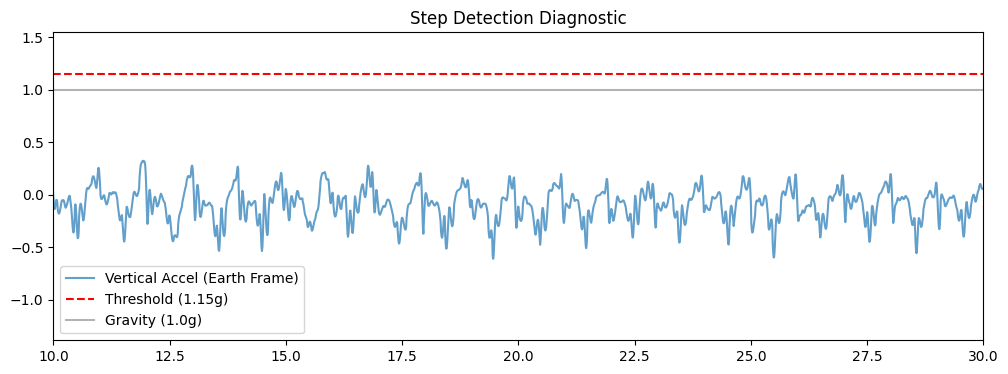

In [14]:
# DIAGNOSTIC 1: Check Step Detection Signals
plt.figure(figsize=(12, 4))
time_axis = (walk_df['Micros'] - walk_df['Micros'].iloc[0]) / 1e6

# Plot the calculated Earth-Frame Vertical Acceleration
# (We assume you have 'az_earth_log' or can regenerate it from the loop)
# If not, quickly re-calc just the 'az_earth' array using the loop code:
az_log = []
ahrs = MadgwickAHRS(beta=0.1)
for i in range(len(walk_df)):
    row = walk_df.iloc[i]
    # ... (insert your sensor prep code here: gx, gy, ax, etc) ...
    # ... (insert ahrs.update) ...
    a_earth = rotate_vec(q, [row['Ax'], row['Ay'], row['Az']])
    az_log.append(a_earth[2])

plt.plot(time_axis, az_log, label='Vertical Accel (Earth Frame)', alpha=0.7)
plt.axhline(1.15, color='r', linestyle='--', label='Threshold (1.15g)')
plt.axhline(1.0, color='k', linestyle='-', alpha=0.3, label='Gravity (1.0g)')
plt.xlim(10, 30) # Zoom in on just 20 seconds of walking
plt.title("Step Detection Diagnostic")
plt.legend()
plt.show()

Gyro Bias: [ 1.371  4.539 -0.173]
Mag Offset: [42.105 20.075 18.605]
Expected Mag Field: 86.90 uT


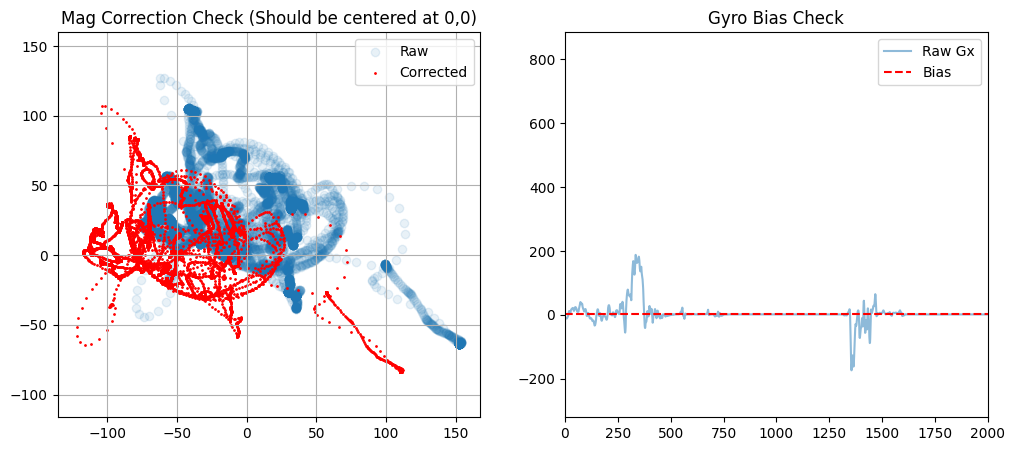

AHRS Aligned. Pitch: 0.9°, Roll: 79.3°
Processing steps...
Total Steps Found: 421


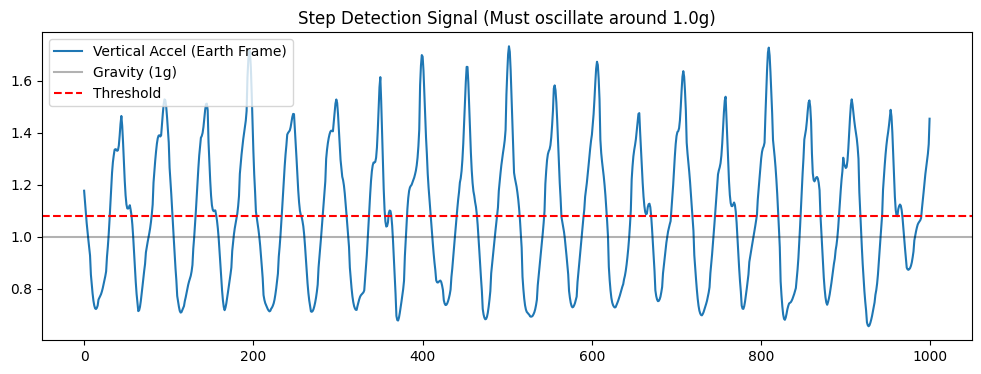

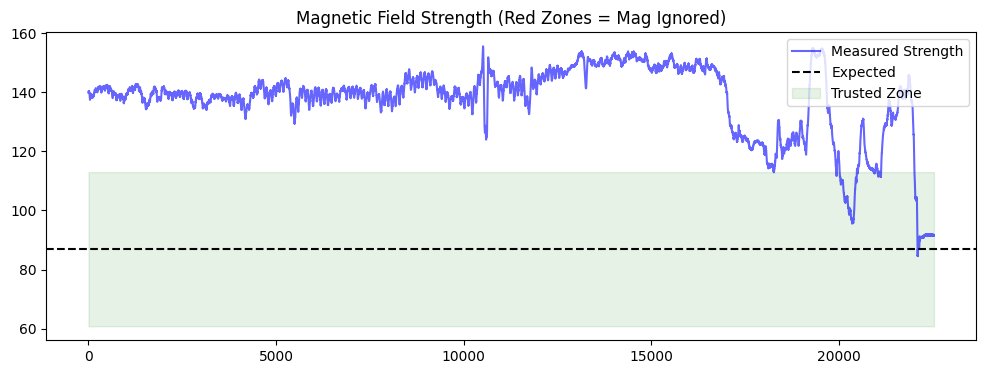

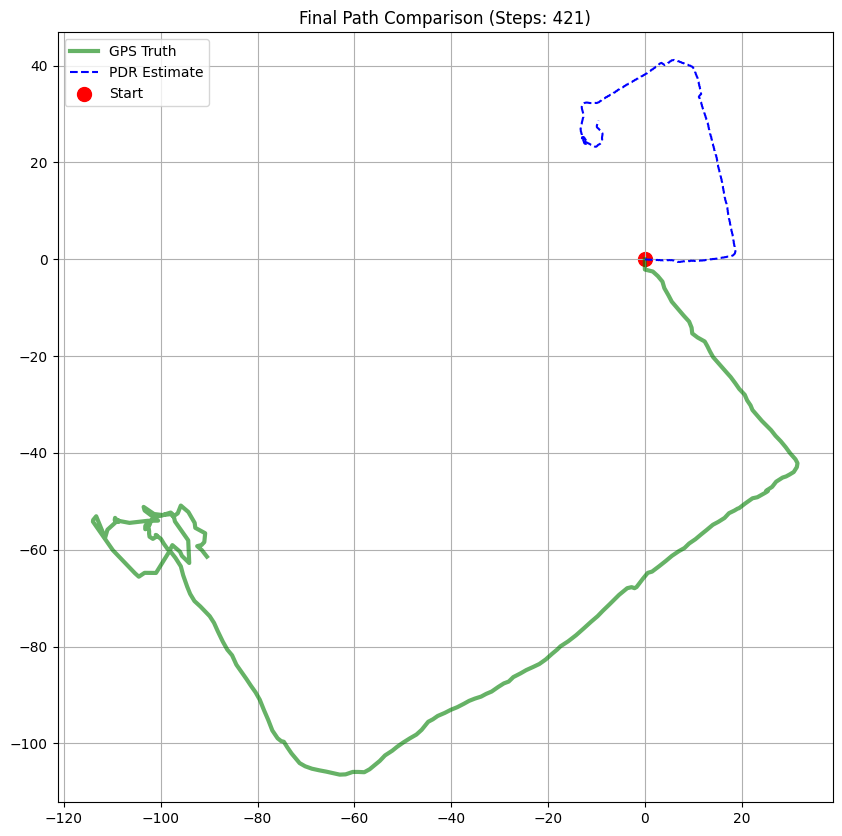

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
# CONFIGURATION & CONSTANTS
# =============================================================================
WALK_FILE = '/home/ollie/Documents/PlatformIO/Projects/lokata/data/raw/walk_data_20260107-090119.csv'
CAL_FILE  = '/home/ollie/Documents/PlatformIO/Projects/lokata/data/raw/walk_data_20260109-222545.csv'

# PDR TUNING
STEP_THRESHOLD = 1.08    # G-force threshold for step detection (1.0 = Gravity)
MIN_STEP_TIME  = 0.35    # Seconds between steps (debounce)
K_WEINBERG     = 0.45    # Stride length multiplier
ROTATION_FIX   = -90     # Degrees to rotate PDR path to align with GPS
MAG_REJECT_PCT = 0.30    # Rejection tolerance (e.g., 0.30 = +/- 30% of expected strength)

# =============================================================================
# 1. CLASSES & HELPER FUNCTIONS
# =============================================================================

class MadgwickAHRS:
    def __init__(self, sampleperiod=0.02, beta=0.1):
        self.sampleperiod = sampleperiod
        self.beta = beta
        self.q = np.array([1.0, 0.0, 0.0, 0.0]) # [w, x, y, z]

    # 9-Axis Update (Gyro + Accel + Mag) -> Used when Mag is GOOD
    def update(self, gyro, acc, mag):
        q = self.q
        gx, gy, gz = gyro
        ax, ay, az = acc
        mx, my, mz = mag
        
        # Guard: If Accel is 0 (freefall/error), don't update
        norm = np.sqrt(ax*ax + ay*ay + az*az)
        if norm == 0: return self.q 
        ax, ay, az = ax/norm, ay/norm, az/norm

        # Guard: If Mag is 0, Fallback to IMU update
        norm = np.sqrt(mx*mx + my*my + mz*mz)
        if norm == 0: return self.updateIMU(gyro, acc)
        mx, my, mz = mx/norm, my/norm, mz/norm

        # Reference direction of Earth's magnetic field
        hx = mx*(q[0]**2 + q[1]**2 - q[2]**2 - q[3]**2) - 2*my*(q[0]*q[3] - q[1]*q[2]) + 2*mz*(q[0]*q[2] + q[1]*q[3])
        hy = 2*mx*(q[0]*q[3] + q[1]*q[2]) + my*(q[0]**2 - q[1]**2 + q[2]**2 - q[3]**2) - 2*mz*(q[0]*q[1] - q[2]*q[3])
        bx = np.sqrt(hx*hx + hy*hy)
        bz = 2*mx*(q[1]*q[3] - q[0]*q[2]) + 2*my*(q[0]*q[1] + q[2]*q[3]) + mz*(q[0]**2 - q[1]**2 - q[2]**2 + q[3]**2)

        # Gradient descent
        s0 = -2*q[2]*(2*q[1]*q[3] - 2*q[0]*q[2] - ax) + 2*q[1]*(2*q[0]*q[1] + 2*q[2]*q[3] - ay) - 2*bz*q[2]*(2*bx*(0.5 - q[2]**2 - q[3]**2) + 2*bz*(q[1]*q[3] - q[0]*q[2]) - mx) + (-2*bx*q[3] + 2*bz*q[1])*(2*bx*(q[1]*q[2] - q[0]*q[3]) + 2*bz*(q[0]*q[1] + q[2]*q[3]) - my) + 2*bx*q[2]*(2*bx*(q[0]*q[2] + q[1]*q[3]) + 2*bz*(0.5 - q[1]**2 - q[2]**2) - mz)
        s1 = 2*q[3]*(2*q[1]*q[3] - 2*q[0]*q[2] - ax) + 2*q[0]*(2*q[0]*q[1] + 2*q[2]*q[3] - ay) - 4*q[1]*(1 - 2*q[1]**2 - 2*q[2]**2 - az) + 2*bz*q[3]*(2*bx*(0.5 - q[2]**2 - q[3]**2) + 2*bz*(q[1]*q[3] - q[0]*q[2]) - mx) + (2*bx*q[2] + 2*bz*q[0])*(2*bx*(q[1]*q[2] - q[0]*q[3]) + 2*bz*(q[0]*q[1] + q[2]*q[3]) - my) + (2*bx*q[3] - 4*bz*q[1])*(2*bx*(q[0]*q[2] + q[1]*q[3]) + 2*bz*(0.5 - q[1]**2 - q[2]**2) - mz)
        s2 = -2*q[0]*(2*q[1]*q[3] - 2*q[0]*q[2] - ax) + 2*q[3]*(2*q[0]*q[1] + 2*q[2]*q[3] - ay) - 4*q[2]*(1 - 2*q[1]**2 - 2*q[2]**2 - az) + (-4*bx*q[2] - 2*bz*q[0])*(2*bx*(0.5 - q[2]**2 - q[3]**2) + 2*bz*(q[1]*q[3] - q[0]*q[2]) - mx) + (2*bx*q[1] + 2*bz*q[3])*(2*bx*(q[1]*q[2] - q[0]*q[3]) + 2*bz*(q[0]*q[1] + q[2]*q[3]) - my) + (2*bx*q[0] - 4*bz*q[2])*(2*bx*(q[0]*q[2] + q[1]*q[3]) + 2*bz*(0.5 - q[1]**2 - q[2]**2) - mz)
        s3 = 2*q[1]*(2*q[1]*q[3] - 2*q[0]*q[2] - ax) + 2*q[2]*(2*q[0]*q[1] + 2*q[2]*q[3] - ay) + (-2*bx*q[3] + 2*bz*q[1])*(2*bx*(0.5 - q[2]**2 - q[3]**2) + 2*bz*(q[1]*q[3] - q[0]*q[2]) - mx) + (-2*bx*q[0] + 2*bz*q[2])*(2*bx*(q[1]*q[2] - q[0]*q[3]) + 2*bz*(q[0]*q[1] + q[2]*q[3]) - my) + 2*bx*q[1]*(2*bx*(q[0]*q[2] + q[1]*q[3]) + 2*bz*(0.5 - q[1]**2 - q[2]**2) - mz)
        
        norm = np.sqrt(s0*s0 + s1*s1 + s2*s2 + s3*s3)
        if norm > 0: s0, s1, s2, s3 = s0/norm, s1/norm, s2/norm, s3/norm

        return self._integrate_gyro(gyro, s0, s1, s2, s3)

    # 6-Axis Update (Gyro + Accel Only) -> Used when Mag is BAD
    def updateIMU(self, gyro, acc):
        q = self.q
        gx, gy, gz = gyro
        ax, ay, az = acc

        norm = np.sqrt(ax*ax + ay*ay + az*az)
        if norm == 0: return self.q
        ax, ay, az = ax/norm, ay/norm, az/norm

        s0 = -2*q[2]*(2*q[1]*q[3] - 2*q[0]*q[2] - ax) + 2*q[1]*(2*q[0]*q[1] + 2*q[2]*q[3] - ay)
        s1 = 2*q[3]*(2*q[1]*q[3] - 2*q[0]*q[2] - ax) + 2*q[0]*(2*q[0]*q[1] + 2*q[2]*q[3] - ay) - 4*q[1]*(1 - 2*q[1]**2 - 2*q[2]**2 - az)
        s2 = -2*q[0]*(2*q[1]*q[3] - 2*q[0]*q[2] - ax) + 2*q[3]*(2*q[0]*q[1] + 2*q[2]*q[3] - ay) - 4*q[2]*(1 - 2*q[1]**2 - 2*q[2]**2 - az)
        s3 = 2*q[1]*(2*q[1]*q[3] - 2*q[0]*q[2] - ax) + 2*q[2]*(2*q[0]*q[1] + 2*q[2]*q[3] - ay)

        norm = np.sqrt(s0*s0 + s1*s1 + s2*s2 + s3*s3)
        if norm > 0: s0, s1, s2, s3 = s0/norm, s1/norm, s2/norm, s3/norm

        return self._integrate_gyro(gyro, s0, s1, s2, s3)

    def _integrate_gyro(self, gyro, s0, s1, s2, s3):
        q = self.q
        gx, gy, gz = gyro
        qDot1 = 0.5 * (-q[1]*gx - q[2]*gy - q[3]*gz) - self.beta * s0
        qDot2 = 0.5 * (q[0]*gx + q[2]*gz - q[3]*gy) - self.beta * s1
        qDot3 = 0.5 * (q[0]*gy - q[1]*gz + q[3]*gx) - self.beta * s2
        qDot4 = 0.5 * (q[0]*gz + q[1]*gy - q[2]*gx) - self.beta * s3

        q[0] += qDot1 * self.sampleperiod
        q[1] += qDot2 * self.sampleperiod
        q[2] += qDot3 * self.sampleperiod
        q[3] += qDot4 * self.sampleperiod
        
        self.q = q / np.linalg.norm(q)
        return self.q

def rotate_vec(q, vec):
    w, x, y, z = q
    vx, vy, vz = vec
    rx = vx*(1 - 2*y*y - 2*z*z) + vy*(2*x*y - 2*z*w) + vz*(2*x*z + 2*y*w)
    ry = vx*(2*x*y + 2*z*w) + vy*(1 - 2*x*x - 2*z*z) + vz*(2*y*z - 2*x*w)
    rz = vx*(2*x*z - 2*y*w) + vy*(2*y*z + 2*x*w) + vz*(1 - 2*x*x - 2*y*y)
    return np.array([rx, ry, rz])

def get_heading(q):
    return np.arctan2(2.0*(q[1]*q[2] + q[0]*q[3]), q[0]**2 + q[1]**2 - q[2]**2 - q[3]**2)

def calibrate_sensors_robust(df):
    results = {}
    
    # Gyro Bias
    acc_mag = np.sqrt(df['Ax']**2 + df['Ay']**2 + df['Az']**2)
    best_window_idx = acc_mag.rolling(window=50).var().idxmin()
    start_idx = max(0, best_window_idx - 50)
    static_df = df.iloc[start_idx : best_window_idx]
    results['gyro_bias'] = np.array([static_df['Gx'].mean(), static_df['Gy'].mean(), static_df['Gz'].mean()])
    
    # Mag Offset (Percentile Rejection)
    mx_min, mx_max = np.percentile(df['Mx'], [2, 98])
    my_min, my_max = np.percentile(df['My'], [2, 98])
    mz_min, mz_max = np.percentile(df['Mz'], [2, 98])
    
    results['mag_offset'] = np.array([(mx_min + mx_max)/2, (my_min + my_max)/2, (mz_min + mz_max)/2])
    
    # Calculate Expected Field Strength from the corrected data
    m_vec = np.vstack([df['Mx']-results['mag_offset'][0], 
                       df['My']-results['mag_offset'][1], 
                       df['Mz']-results['mag_offset'][2]]).T
    # We filter out extreme outliers before calculating mean strength
    norms = np.linalg.norm(m_vec, axis=1)
    lower, upper = np.percentile(norms, [5, 95])
    results['expected_strength'] = np.mean(norms[(norms > lower) & (norms < upper)])
    
    return results

# =============================================================================
# 2. DATA LOAD & CALIBRATION
# =============================================================================

cal_df = pd.read_csv(CAL_FILE)
walk_df = pd.read_csv(WALK_FILE)

# Clean GPS and Fix Timestamps
walk_df['Lat_deg'] = walk_df['Lat'] / 1e7
walk_df['Lon_deg'] = walk_df['Lon'] / 1e7
walk_df = walk_df[(walk_df['Lat_deg'] != 0) & (walk_df['Lon_deg'] != 0)].dropna(subset=['Lat_deg', 'Lon_deg'])
walk_df.rename(columns={'Millis': 'Micros'}, inplace=True)

# --- RUN CALIBRATION ---
cal_params = calibrate_sensors_robust(cal_df)
gyro_bias = cal_params['gyro_bias']
mag_offset = cal_params['mag_offset']
expected_mag = cal_params['expected_strength']

print(f"Gyro Bias: {gyro_bias.round(3)}")
print(f"Mag Offset: {mag_offset.round(3)}")
print(f"Expected Mag Field: {expected_mag:.2f} uT")

# --- DIAGNOSTIC PLOT 1: SENSOR CALIBRATION ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Mag Correction Check (Should be centered at 0,0)")
plt.scatter(cal_df['Mx'], cal_df['My'], alpha=0.1, label='Raw')
plt.scatter(cal_df['Mx']-mag_offset[0], cal_df['My']-mag_offset[1], s=1, color='r', label='Corrected')
plt.axis('equal')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title("Gyro Bias Check")
plt.plot(cal_df['Gx'], alpha=0.5, label='Raw Gx')
plt.axhline(gyro_bias[0], color='r', linestyle='--', label='Bias')
plt.xlim(0, 2000) # Zoom in to see the bias line
plt.legend()
plt.show()

# =============================================================================
# 3. INITIALIZATION & GRAVITY ALIGNMENT
# =============================================================================

ahrs = MadgwickAHRS(beta=0.1)

# Align to Gravity
init_acc = walk_df[['Ax', 'Ay', 'Az']].iloc[:50].mean().values
norm_acc = np.linalg.norm(init_acc)
if norm_acc > 0:
    ax_i, ay_i, az_i = init_acc / norm_acc
    initial_roll = np.arctan2(ay_i, az_i)
    initial_pitch = np.arctan2(-ax_i, np.sqrt(ay_i**2 + az_i**2))
    
    cr, sr = np.cos(initial_roll*0.5), np.sin(initial_roll*0.5)
    cp, sp = np.cos(initial_pitch*0.5), np.sin(initial_pitch*0.5)
    ahrs.q = np.array([cr*cp, sr*cp, cr*sp, -sr*sp]) # [w, x, y, z]
    print(f"AHRS Aligned. Pitch: {np.degrees(initial_pitch):.1f}°, Roll: {np.degrees(initial_roll):.1f}°")

# =============================================================================
# 4. PROCESSING LOOP (PDR)
# =============================================================================

pdr_path = []
az_log = []     # For step detection plot
mag_log = []    # For anomaly rejection plot
last_step_time = 0
current_x, current_y = 0, 0
step_detected = False

micros = walk_df['Micros'].values
prev_t = micros[0]

print("Processing steps...")
for i in range(len(walk_df)):
    row = walk_df.iloc[i]
    curr_t = row['Micros']
    dt = (curr_t - prev_t) / 1e6
    prev_t = curr_t
    
    if dt > 0.1 or dt <= 0: dt = 0.05 
    ahrs.sampleperiod = dt
    
    # Raw Inputs (Corrected)
    gx, gy, gz = np.deg2rad([row['Gx']-gyro_bias[0], row['Gy']-gyro_bias[1], row['Gz']-gyro_bias[2]])
    mx, my, mz = row['Mx']-mag_offset[0], row['My']-mag_offset[1], row['Mz']-mag_offset[2]
    ax, ay, az = row['Ax'], row['Ay'], row['Az']
    
    # Mag Anomaly Logic
    mag_strength = np.sqrt(mx**2 + my**2 + mz**2)
    mag_log.append(mag_strength)
    
    is_mag_good = ((1.0 - MAG_REJECT_PCT) * expected_mag < mag_strength < (1.0 + MAG_REJECT_PCT) * expected_mag)
    
    if is_mag_good:
        q = ahrs.update([gx, gy, gz], [ax, ay, az], [mx, my, mz])
    else:
        q = ahrs.updateIMU([gx, gy, gz], [ax, ay, az]) # FALLBACK
        
    heading = get_heading(q)
    
    # Step Detection
    a_earth = rotate_vec(q, [ax, ay, az])
    az_earth = a_earth[2]
    az_log.append(az_earth)
    
    t_sec = curr_t / 1e6
    if (az_earth > STEP_THRESHOLD) and (not step_detected) and (t_sec - last_step_time > MIN_STEP_TIME):
        step_detected = True
        bounce = max(az_earth - 1.0, 0.01)
        stride = K_WEINBERG * (bounce ** 0.25)
        
        current_x += stride * np.sin(heading)
        current_y += stride * np.cos(heading)
        last_step_time = t_sec
        pdr_path.append([curr_t, current_x, current_y])
        
    elif az_earth < (STEP_THRESHOLD - 0.05):
        step_detected = False

pdr_df = pd.DataFrame(pdr_path, columns=['Micros', 'x', 'y'])
print(f"Total Steps Found: {len(pdr_df)}")

# =============================================================================
# 5. DIAGNOSTICS & RESULTS
# =============================================================================

# --- DIAGNOSTIC PLOT 2: GRAVITY ALIGNMENT ---
# This proves if the "Vertical" acceleration is truly vertical
plt.figure(figsize=(12, 4))
plt.title("Step Detection Signal (Must oscillate around 1.0g)")
plt.plot(az_log[:1000], label='Vertical Accel (Earth Frame)') # First 1000 samples
plt.axhline(1.0, color='k', linestyle='-', alpha=0.3, label='Gravity (1g)')
plt.axhline(STEP_THRESHOLD, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

# --- DIAGNOSTIC PLOT 3: MAG ANOMALIES ---
# This shows how often the magnetometer was ignored
plt.figure(figsize=(12, 4))
plt.title("Magnetic Field Strength (Red Zones = Mag Ignored)")
plt.plot(mag_log, color='blue', alpha=0.6, label='Measured Strength')
plt.axhline(expected_mag, color='k', linestyle='--', label='Expected')
plt.fill_between(range(len(mag_log)), 
                 (1-MAG_REJECT_PCT)*expected_mag, 
                 (1+MAG_REJECT_PCT)*expected_mag, 
                 color='green', alpha=0.1, label='Trusted Zone')
plt.legend()
plt.show()

# --- DIAGNOSTIC PLOT 4: GPS vs PDR COMPARISON ---
if not pdr_df.empty:
    # Convert GPS to Local Meters
    lat0, lon0 = walk_df['Lat_deg'].iloc[0], walk_df['Lon_deg'].iloc[0]
    R = 6371000
    gps_x = np.radians(walk_df['Lon_deg'] - lon0) * np.cos(np.radians(lat0)) * R
    gps_y = np.radians(walk_df['Lat_deg'] - lat0) * R
    
    # Rotate PDR
    theta = np.radians(ROTATION_FIX)
    pdr_x_raw = pdr_df['x'].values - pdr_df['x'].values[0]
    pdr_y_raw = pdr_df['y'].values - pdr_df['y'].values[0]
    
    pdr_x_rot = pdr_x_raw * np.cos(theta) - pdr_y_raw * np.sin(theta)
    pdr_y_rot = pdr_x_raw * np.sin(theta) + pdr_y_raw * np.cos(theta)

    plt.figure(figsize=(10, 10))
    plt.plot(gps_x, gps_y, 'g-', linewidth=3, alpha=0.6, label='GPS Truth')
    plt.plot(pdr_x_rot, pdr_y_rot, 'b--', label='PDR Estimate')
    plt.scatter(0,0, c='red', s=100, label='Start')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.title(f"Final Path Comparison (Steps: {len(pdr_df)})")
    plt.show()
else:
    print("NO STEPS DETECTED - CHECK THRESHOLD OR GRAVITY ALIGNMENT!")

Gyro Bias: [ 1.371  4.539 -0.173]
Mag Offset: [42.105 20.075 18.605]
Expected Mag Field: 86.90 uT


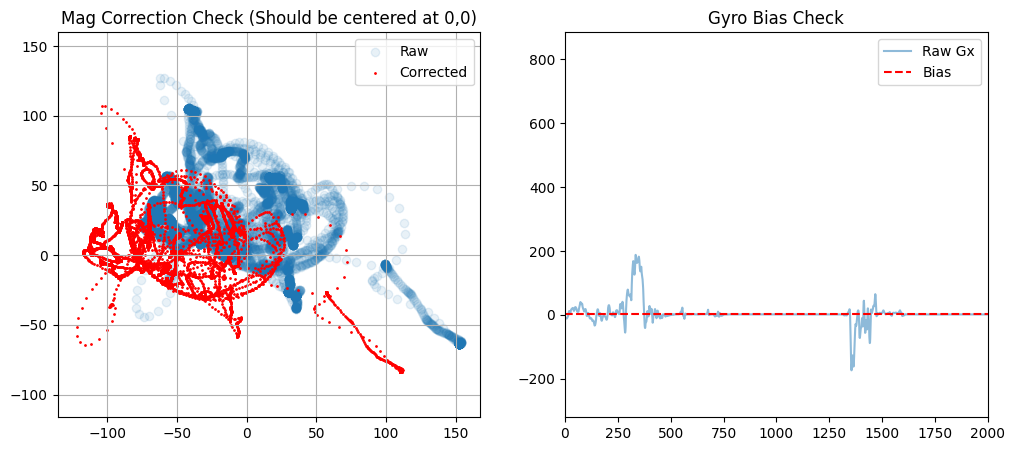

AHRS Aligned. Pitch: 0.9°, Roll: 79.3°
Processing steps...
Total Steps Found: 421


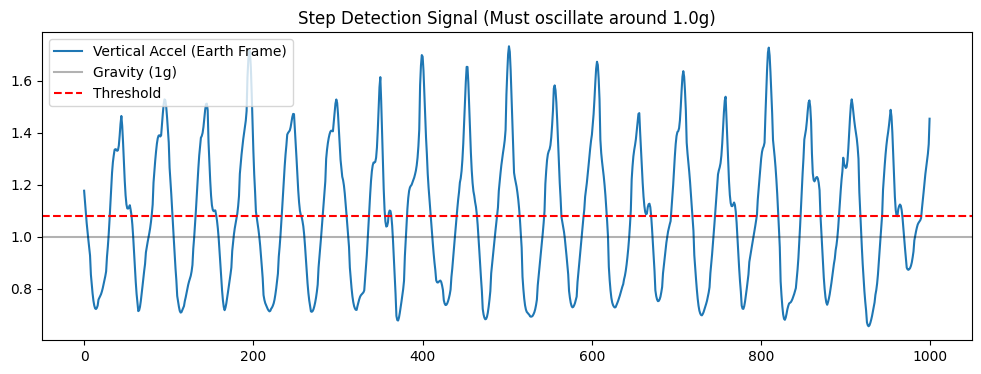

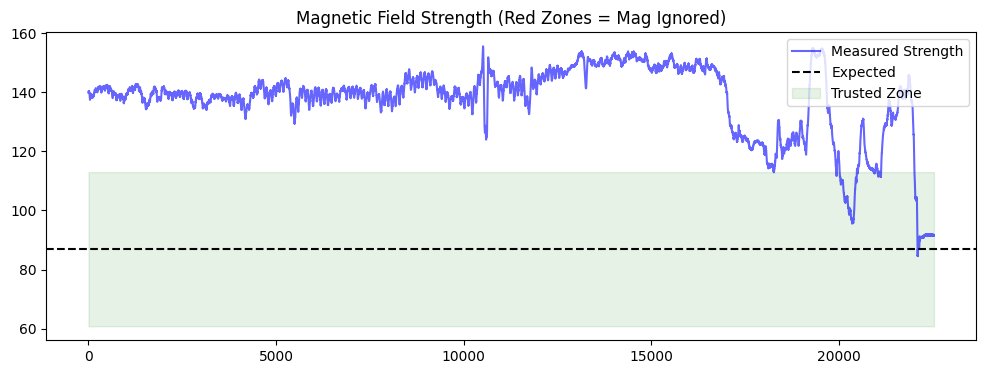

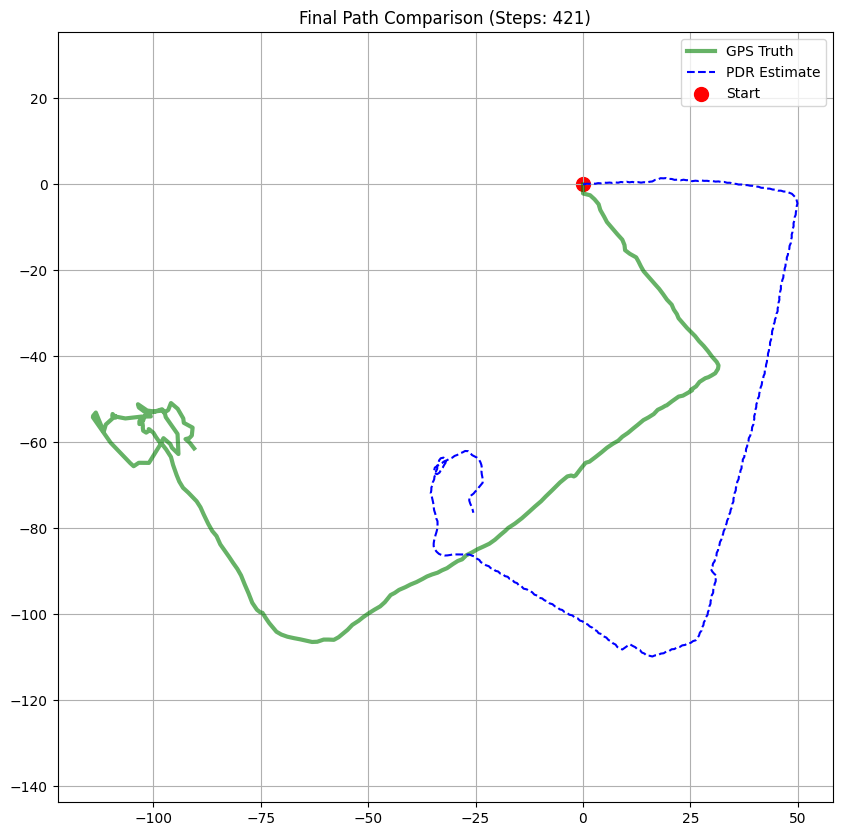

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
# CONFIGURATION & CONSTANTS
# =============================================================================
WALK_FILE = '/home/ollie/Documents/PlatformIO/Projects/lokata/data/raw/walk_data_20260107-090119.csv'
CAL_FILE  = '/home/ollie/Documents/PlatformIO/Projects/lokata/data/raw/walk_data_20260109-222545.csv'

# PDR TUNING
STEP_THRESHOLD = 1.08    # G-force threshold for step detection (1.0 = Gravity)
MIN_STEP_TIME  = 0.35    # Seconds between steps (debounce)
K_WEINBERG     = 1.2    # Stride length multiplier
ROTATION_FIX   = -90     # Degrees to rotate PDR path to align with GPS
MAG_REJECT_PCT = 0.30    # Rejection tolerance (e.g., 0.30 = +/- 30% of expected strength)
HEADING_SCALE  = -1.0    # Heading correction scale (1.0 = no correction, -1 = right is left)

# =============================================================================
# 1. CLASSES & HELPER FUNCTIONS
# =============================================================================

class MadgwickAHRS:
    def __init__(self, sampleperiod=0.02, beta=0.1):
        self.sampleperiod = sampleperiod
        self.beta = beta
        self.q = np.array([1.0, 0.0, 0.0, 0.0]) # [w, x, y, z]

    # 9-Axis Update (Gyro + Accel + Mag) -> Used when Mag is GOOD
    def update(self, gyro, acc, mag):
        q = self.q
        gx, gy, gz = gyro
        ax, ay, az = acc
        mx, my, mz = mag
        
        # Guard: If Accel is 0 (freefall/error), don't update
        norm = np.sqrt(ax*ax + ay*ay + az*az)
        if norm == 0: return self.q 
        ax, ay, az = ax/norm, ay/norm, az/norm

        # Guard: If Mag is 0, Fallback to IMU update
        norm = np.sqrt(mx*mx + my*my + mz*mz)
        if norm == 0: return self.updateIMU(gyro, acc)
        mx, my, mz = mx/norm, my/norm, mz/norm

        # Reference direction of Earth's magnetic field
        hx = mx*(q[0]**2 + q[1]**2 - q[2]**2 - q[3]**2) - 2*my*(q[0]*q[3] - q[1]*q[2]) + 2*mz*(q[0]*q[2] + q[1]*q[3])
        hy = 2*mx*(q[0]*q[3] + q[1]*q[2]) + my*(q[0]**2 - q[1]**2 + q[2]**2 - q[3]**2) - 2*mz*(q[0]*q[1] - q[2]*q[3])
        bx = np.sqrt(hx*hx + hy*hy)
        bz = 2*mx*(q[1]*q[3] - q[0]*q[2]) + 2*my*(q[0]*q[1] + q[2]*q[3]) + mz*(q[0]**2 - q[1]**2 - q[2]**2 + q[3]**2)

        # Gradient descent
        s0 = -2*q[2]*(2*q[1]*q[3] - 2*q[0]*q[2] - ax) + 2*q[1]*(2*q[0]*q[1] + 2*q[2]*q[3] - ay) - 2*bz*q[2]*(2*bx*(0.5 - q[2]**2 - q[3]**2) + 2*bz*(q[1]*q[3] - q[0]*q[2]) - mx) + (-2*bx*q[3] + 2*bz*q[1])*(2*bx*(q[1]*q[2] - q[0]*q[3]) + 2*bz*(q[0]*q[1] + q[2]*q[3]) - my) + 2*bx*q[2]*(2*bx*(q[0]*q[2] + q[1]*q[3]) + 2*bz*(0.5 - q[1]**2 - q[2]**2) - mz)
        s1 = 2*q[3]*(2*q[1]*q[3] - 2*q[0]*q[2] - ax) + 2*q[0]*(2*q[0]*q[1] + 2*q[2]*q[3] - ay) - 4*q[1]*(1 - 2*q[1]**2 - 2*q[2]**2 - az) + 2*bz*q[3]*(2*bx*(0.5 - q[2]**2 - q[3]**2) + 2*bz*(q[1]*q[3] - q[0]*q[2]) - mx) + (2*bx*q[2] + 2*bz*q[0])*(2*bx*(q[1]*q[2] - q[0]*q[3]) + 2*bz*(q[0]*q[1] + q[2]*q[3]) - my) + (2*bx*q[3] - 4*bz*q[1])*(2*bx*(q[0]*q[2] + q[1]*q[3]) + 2*bz*(0.5 - q[1]**2 - q[2]**2) - mz)
        s2 = -2*q[0]*(2*q[1]*q[3] - 2*q[0]*q[2] - ax) + 2*q[3]*(2*q[0]*q[1] + 2*q[2]*q[3] - ay) - 4*q[2]*(1 - 2*q[1]**2 - 2*q[2]**2 - az) + (-4*bx*q[2] - 2*bz*q[0])*(2*bx*(0.5 - q[2]**2 - q[3]**2) + 2*bz*(q[1]*q[3] - q[0]*q[2]) - mx) + (2*bx*q[1] + 2*bz*q[3])*(2*bx*(q[1]*q[2] - q[0]*q[3]) + 2*bz*(q[0]*q[1] + q[2]*q[3]) - my) + (2*bx*q[0] - 4*bz*q[2])*(2*bx*(q[0]*q[2] + q[1]*q[3]) + 2*bz*(0.5 - q[1]**2 - q[2]**2) - mz)
        s3 = 2*q[1]*(2*q[1]*q[3] - 2*q[0]*q[2] - ax) + 2*q[2]*(2*q[0]*q[1] + 2*q[2]*q[3] - ay) + (-2*bx*q[3] + 2*bz*q[1])*(2*bx*(0.5 - q[2]**2 - q[3]**2) + 2*bz*(q[1]*q[3] - q[0]*q[2]) - mx) + (-2*bx*q[0] + 2*bz*q[2])*(2*bx*(q[1]*q[2] - q[0]*q[3]) + 2*bz*(q[0]*q[1] + q[2]*q[3]) - my) + 2*bx*q[1]*(2*bx*(q[0]*q[2] + q[1]*q[3]) + 2*bz*(0.5 - q[1]**2 - q[2]**2) - mz)
        
        norm = np.sqrt(s0*s0 + s1*s1 + s2*s2 + s3*s3)
        if norm > 0: s0, s1, s2, s3 = s0/norm, s1/norm, s2/norm, s3/norm

        return self._integrate_gyro(gyro, s0, s1, s2, s3)

    # 6-Axis Update (Gyro + Accel Only) -> Used when Mag is BAD
    def updateIMU(self, gyro, acc):
        q = self.q
        gx, gy, gz = gyro
        ax, ay, az = acc

        norm = np.sqrt(ax*ax + ay*ay + az*az)
        if norm == 0: return self.q
        ax, ay, az = ax/norm, ay/norm, az/norm

        s0 = -2*q[2]*(2*q[1]*q[3] - 2*q[0]*q[2] - ax) + 2*q[1]*(2*q[0]*q[1] + 2*q[2]*q[3] - ay)
        s1 = 2*q[3]*(2*q[1]*q[3] - 2*q[0]*q[2] - ax) + 2*q[0]*(2*q[0]*q[1] + 2*q[2]*q[3] - ay) - 4*q[1]*(1 - 2*q[1]**2 - 2*q[2]**2 - az)
        s2 = -2*q[0]*(2*q[1]*q[3] - 2*q[0]*q[2] - ax) + 2*q[3]*(2*q[0]*q[1] + 2*q[2]*q[3] - ay) - 4*q[2]*(1 - 2*q[1]**2 - 2*q[2]**2 - az)
        s3 = 2*q[1]*(2*q[1]*q[3] - 2*q[0]*q[2] - ax) + 2*q[2]*(2*q[0]*q[1] + 2*q[2]*q[3] - ay)

        norm = np.sqrt(s0*s0 + s1*s1 + s2*s2 + s3*s3)
        if norm > 0: s0, s1, s2, s3 = s0/norm, s1/norm, s2/norm, s3/norm

        return self._integrate_gyro(gyro, s0, s1, s2, s3)

    def _integrate_gyro(self, gyro, s0, s1, s2, s3):
        q = self.q
        gx, gy, gz = gyro
        qDot1 = 0.5 * (-q[1]*gx - q[2]*gy - q[3]*gz) - self.beta * s0
        qDot2 = 0.5 * (q[0]*gx + q[2]*gz - q[3]*gy) - self.beta * s1
        qDot3 = 0.5 * (q[0]*gy - q[1]*gz + q[3]*gx) - self.beta * s2
        qDot4 = 0.5 * (q[0]*gz + q[1]*gy - q[2]*gx) - self.beta * s3

        q[0] += qDot1 * self.sampleperiod
        q[1] += qDot2 * self.sampleperiod
        q[2] += qDot3 * self.sampleperiod
        q[3] += qDot4 * self.sampleperiod
        
        self.q = q / np.linalg.norm(q)
        return self.q

def rotate_vec(q, vec):
    w, x, y, z = q
    vx, vy, vz = vec
    rx = vx*(1 - 2*y*y - 2*z*z) + vy*(2*x*y - 2*z*w) + vz*(2*x*z + 2*y*w)
    ry = vx*(2*x*y + 2*z*w) + vy*(1 - 2*x*x - 2*z*z) + vz*(2*y*z - 2*x*w)
    rz = vx*(2*x*z - 2*y*w) + vy*(2*y*z + 2*x*w) + vz*(1 - 2*x*x - 2*y*y)
    return np.array([rx, ry, rz])

def get_heading(q):
    return np.arctan2(2.0*(q[1]*q[2] + q[0]*q[3]), q[0]**2 + q[1]**2 - q[2]**2 - q[3]**2)

def calibrate_sensors_robust(df):
    results = {}
    
    # Gyro Bias
    acc_mag = np.sqrt(df['Ax']**2 + df['Ay']**2 + df['Az']**2)
    best_window_idx = acc_mag.rolling(window=50).var().idxmin()
    start_idx = max(0, best_window_idx - 50)
    static_df = df.iloc[start_idx : best_window_idx]
    results['gyro_bias'] = np.array([static_df['Gx'].mean(), static_df['Gy'].mean(), static_df['Gz'].mean()])
    
    # Mag Offset (Percentile Rejection)
    mx_min, mx_max = np.percentile(df['Mx'], [2, 98])
    my_min, my_max = np.percentile(df['My'], [2, 98])
    mz_min, mz_max = np.percentile(df['Mz'], [2, 98])
    
    results['mag_offset'] = np.array([(mx_min + mx_max)/2, (my_min + my_max)/2, (mz_min + mz_max)/2])
    
    # Calculate Expected Field Strength from the corrected data
    m_vec = np.vstack([df['Mx']-results['mag_offset'][0], 
                       df['My']-results['mag_offset'][1], 
                       df['Mz']-results['mag_offset'][2]]).T
    # We filter out extreme outliers before calculating mean strength
    norms = np.linalg.norm(m_vec, axis=1)
    lower, upper = np.percentile(norms, [5, 95])
    results['expected_strength'] = np.mean(norms[(norms > lower) & (norms < upper)])
    
    return results

# =============================================================================
# 2. DATA LOAD & CALIBRATION
# =============================================================================

cal_df = pd.read_csv(CAL_FILE)
walk_df = pd.read_csv(WALK_FILE)

# Clean GPS and Fix Timestamps
walk_df['Lat_deg'] = walk_df['Lat'] / 1e7
walk_df['Lon_deg'] = walk_df['Lon'] / 1e7
walk_df = walk_df[(walk_df['Lat_deg'] != 0) & (walk_df['Lon_deg'] != 0)].dropna(subset=['Lat_deg', 'Lon_deg'])
walk_df.rename(columns={'Millis': 'Micros'}, inplace=True)

# --- RUN CALIBRATION ---
cal_params = calibrate_sensors_robust(cal_df)
gyro_bias = cal_params['gyro_bias']
mag_offset = cal_params['mag_offset']
expected_mag = cal_params['expected_strength']

print(f"Gyro Bias: {gyro_bias.round(3)}")
print(f"Mag Offset: {mag_offset.round(3)}")
print(f"Expected Mag Field: {expected_mag:.2f} uT")

# --- DIAGNOSTIC PLOT 1: SENSOR CALIBRATION ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Mag Correction Check (Should be centered at 0,0)")
plt.scatter(cal_df['Mx'], cal_df['My'], alpha=0.1, label='Raw')
plt.scatter(cal_df['Mx']-mag_offset[0], cal_df['My']-mag_offset[1], s=1, color='r', label='Corrected')
plt.axis('equal')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title("Gyro Bias Check")
plt.plot(cal_df['Gx'], alpha=0.5, label='Raw Gx')
plt.axhline(gyro_bias[0], color='r', linestyle='--', label='Bias')
plt.xlim(0, 2000) # Zoom in to see the bias line
plt.legend()
plt.show()

# =============================================================================
# 3. INITIALIZATION & GRAVITY ALIGNMENT
# =============================================================================

ahrs = MadgwickAHRS(beta=0.1)

# Align to Gravity
init_acc = walk_df[['Ax', 'Ay', 'Az']].iloc[:50].mean().values
norm_acc = np.linalg.norm(init_acc)
if norm_acc > 0:
    ax_i, ay_i, az_i = init_acc / norm_acc
    initial_roll = np.arctan2(ay_i, az_i)
    initial_pitch = np.arctan2(-ax_i, np.sqrt(ay_i**2 + az_i**2))
    
    cr, sr = np.cos(initial_roll*0.5), np.sin(initial_roll*0.5)
    cp, sp = np.cos(initial_pitch*0.5), np.sin(initial_pitch*0.5)
    ahrs.q = np.array([cr*cp, sr*cp, cr*sp, -sr*sp]) # [w, x, y, z]
    print(f"AHRS Aligned. Pitch: {np.degrees(initial_pitch):.1f}°, Roll: {np.degrees(initial_roll):.1f}°")

# =============================================================================
# 4. PROCESSING LOOP (PDR)
# =============================================================================

pdr_path = []
az_log = []     # For step detection plot
mag_log = []    # For anomaly rejection plot
last_step_time = 0
current_x, current_y = 0, 0
step_detected = False

micros = walk_df['Micros'].values
prev_t = micros[0]

print("Processing steps...")
for i in range(len(walk_df)):
    row = walk_df.iloc[i]
    curr_t = row['Micros']
    dt = (curr_t - prev_t) / 1e6
    prev_t = curr_t
    
    if dt > 0.1 or dt <= 0: dt = 0.05 
    ahrs.sampleperiod = dt
    
    # Raw Inputs (Corrected)
    gx, gy, gz = np.deg2rad([row['Gx']-gyro_bias[0], row['Gy']-gyro_bias[1], row['Gz']-gyro_bias[2]])
    mx, my, mz = row['Mx']-mag_offset[0], row['My']-mag_offset[1], row['Mz']-mag_offset[2]
    ax, ay, az = row['Ax'], row['Ay'], row['Az']
    
    # Mag Anomaly Logic
    mag_strength = np.sqrt(mx**2 + my**2 + mz**2)
    mag_log.append(mag_strength)
    
    is_mag_good = ((1.0 - MAG_REJECT_PCT) * expected_mag < mag_strength < (1.0 + MAG_REJECT_PCT) * expected_mag)
    
    if is_mag_good:
        q = ahrs.update([gx, gy, gz], [ax, ay, az], [mx, my, mz])
    else:
        q = ahrs.updateIMU([gx, gy, gz], [ax, ay, az]) # FALLBACK
        
    # 1. Get Raw Heading
    raw_heading = get_heading(q)
    
    # 2. APPLY MIRROR FIX HERE
    # We multiply by -1.0 if HEADING_SCALE is set to negative
    heading = raw_heading * HEADING_SCALE 
    
    # Step Detection
    a_earth = rotate_vec(q, [ax, ay, az])
    az_earth = a_earth[2]
    az_log.append(az_earth)
    
    t_sec = curr_t / 1e6
    if (az_earth > STEP_THRESHOLD) and (not step_detected) and (t_sec - last_step_time > MIN_STEP_TIME):
        step_detected = True
        
        # Weinberg Step Length Estimation
        # We cap the bounce to avoid errors if accel noise is low
        bounce = max(az_earth - 1.0, 0.01) 
        
        # Calculate stride
        stride = K_WEINBERG * (bounce ** 0.25)
        
        # OPTIONAL: Clamp stride to realistic limits for a 1.9m person (0.5m to 1.2m)
        # This prevents sensor noise from teleporting you 
        stride = min(max(stride, 0.4), 1.3)
        
        current_x += stride * np.sin(heading)
        current_y += stride * np.cos(heading)
        
        last_step_time = t_sec
        pdr_path.append([curr_t, current_x, current_y])
        
    elif az_earth < (STEP_THRESHOLD - 0.05):
        step_detected = False

pdr_df = pd.DataFrame(pdr_path, columns=['Micros', 'x', 'y'])
print(f"Total Steps Found: {len(pdr_df)}")

# =============================================================================
# 5. DIAGNOSTICS & RESULTS
# =============================================================================

# --- DIAGNOSTIC PLOT 2: GRAVITY ALIGNMENT ---
# This proves if the "Vertical" acceleration is truly vertical
plt.figure(figsize=(12, 4))
plt.title("Step Detection Signal (Must oscillate around 1.0g)")
plt.plot(az_log[:1000], label='Vertical Accel (Earth Frame)') # First 1000 samples
plt.axhline(1.0, color='k', linestyle='-', alpha=0.3, label='Gravity (1g)')
plt.axhline(STEP_THRESHOLD, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

# --- DIAGNOSTIC PLOT 3: MAG ANOMALIES ---
# This shows how often the magnetometer was ignored
plt.figure(figsize=(12, 4))
plt.title("Magnetic Field Strength (Red Zones = Mag Ignored)")
plt.plot(mag_log, color='blue', alpha=0.6, label='Measured Strength')
plt.axhline(expected_mag, color='k', linestyle='--', label='Expected')
plt.fill_between(range(len(mag_log)), 
                 (1-MAG_REJECT_PCT)*expected_mag, 
                 (1+MAG_REJECT_PCT)*expected_mag, 
                 color='green', alpha=0.1, label='Trusted Zone')
plt.legend()
plt.show()

# --- DIAGNOSTIC PLOT 4: GPS vs PDR COMPARISON ---
if not pdr_df.empty:
    # Convert GPS to Local Meters
    lat0, lon0 = walk_df['Lat_deg'].iloc[0], walk_df['Lon_deg'].iloc[0]
    R = 6371000
    gps_x = np.radians(walk_df['Lon_deg'] - lon0) * np.cos(np.radians(lat0)) * R
    gps_y = np.radians(walk_df['Lat_deg'] - lat0) * R
    
    # Rotate PDR
    theta = np.radians(ROTATION_FIX)
    pdr_x_raw = pdr_df['x'].values - pdr_df['x'].values[0]
    pdr_y_raw = pdr_df['y'].values - pdr_df['y'].values[0]
    
    pdr_x_rot = pdr_x_raw * np.cos(theta) - pdr_y_raw * np.sin(theta)
    pdr_y_rot = pdr_x_raw * np.sin(theta) + pdr_y_raw * np.cos(theta)

    plt.figure(figsize=(10, 10))
    plt.plot(gps_x, gps_y, 'g-', linewidth=3, alpha=0.6, label='GPS Truth')
    plt.plot(pdr_x_rot, pdr_y_rot, 'b--', label='PDR Estimate')
    plt.scatter(0,0, c='red', s=100, label='Start')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.title(f"Final Path Comparison (Steps: {len(pdr_df)})")
    plt.show()
else:
    print("NO STEPS DETECTED - CHECK THRESHOLD OR GRAVITY ALIGNMENT!")